In [1]:
from cmath import log
import uproot as up
import awkward as ak
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema, TreeMakerSchema
from coffea import processor
from coffea.nanoevents.methods import candidate
from coffea import lookup_tools
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory, CorrectedMETFactory
from coffea.btag_tools.btagscalefactor import BTagScaleFactor
ak.behavior.update(candidate.behavior)
from template.temp_class import ntuplize
import numpy as np
import argparse
import os
from utils import common_helper as com
from utils import analyze_helper as ana
from coffea import hist as chist

# import logging
# logger = logging.getLogger('sel_module')

In [2]:
# filename = '/data/pubfs/pku_visitor/public_write/download/datasets/nanov7/WpWpJJ_EWK_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM/76696E8F-CCDE-7446-948B-2A572CE7E6C4.root'
# filename = '/data/pubfs/pku_visitor/public_write/download/datasets/nanov7/DoubleMuon/Run2018A-02Apr2020-v1/NANOAOD/AD63A27E-7342-5A4C-95F2-4FB6E1B8B6D4.root'
# isdata=True
# events = uproot.open('/data/pubfs/pku_visitor/public_write/download/datasets/nanov7/WpWpJJ_EWK_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM/76696E8F-CCDE-7446-948B-2A572CE7E6C4.root:Events')
filename = '/data/pubfs/pku_visitor/public_write/download/datasets/nanov7/WpWpJJ_EWK_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM/76696E8F-CCDE-7446-948B-2A572CE7E6C4.root'
# filename = '/data/pubfs/pku_visitor/public_write/download/datasets/nanov7/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM/77F36D6F-1209-B242-BEEF-66CB4A785A78.root'
isdata=False
# events_compared = up.open('/data/pubfs/tyyang99/leptonic_2018_v1/WpWpJJ_EWK_TuneCP5_13TeV-madgraph-pythia8/WpWpJJ_EWK_2018/211026_170443/0000/tree_1.root:Events')

In [3]:
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()

In [4]:
year = '2018'
if isdata==True:
    lumi_mask = ana.get_lumi_mask(events, year)
    events = events[lumi_mask]
muons = events.Muon
electrons = events.Electron
taus = events.Tau
jets = events.Jet
MET = events.MET
puppimet = events.PuppiMET

In [5]:
#definition of loose or tight muons/electrons
events['nmuons'] = np.sum(ak.ones_like(muons.pt),axis=1)
events['nelectrons'] = np.sum(ak.ones_like(electrons.pt),axis=1)
events['njets'] = np.sum(ak.ones_like(jets.pt),axis=1)
events['nleps'] = events.nmuons+events.nelectrons

muons['pt_orig'] = muons.pt
muons['pt'],muons['pt_roccor_up'],muons['pt_roccor_down'] = ana.apply_rochester_correction(muons,data=isdata,year=year)
# electrons['corrected_pt'] = electrons.pt

#muon definition
muon_ip = (abs(muons.dz)<0.1) & (((muons.pt<20) & (abs(muons.dxy)<0.01)) | ((muons.pt>20) & (abs(muons.dxy)<0.02)))
veto_muon_sel = muons.looseId & (muons.pt>10) & (abs(muons.eta)<2.4)
loose_muon_sel = muon_ip & (muons.pt>10) & (abs(muons.eta)<2.4) & muons.tightId & (muons.pfRelIso04_all<0.4)
tight_muon_sel = loose_muon_sel & (muons.pfRelIso04_all<0.15)

if isdata==True:
    pass
else:
    muons['is_real'] = (~np.isnan(ak.fill_none(muons.matched_gen.pt, np.nan)))*1

muons['isveto'] = veto_muon_sel
muons['isloose'] = loose_muon_sel
muons['istight'] = tight_muon_sel
muons['istightcharge'] = (muons.tightCharge>1)
muons['iselectron'] = ak.zeros_like(muons.pt)
muons['ismuon'] = ak.ones_like(muons.pt)
events['nveto_muons'] = np.sum(veto_muon_sel,axis=1)
events['nloose_muons'] = np.sum(loose_muon_sel,axis=1)
events['ntight_muons'] = np.sum(tight_muon_sel,axis=1)

veto_muons = muons[muons.isveto]
good_muons = muons[muons.isloose]

#election definition: the same as latino
loose_elec_barrel = (abs(electrons.eta + electrons.deltaEtaSC) < 1.479) & (abs(electrons.dz) < 0.1) & (abs(electrons.dxy) < 0.05)
Combined_Isolation_Barrel = (electrons.dr03TkSumPt+(1*((electrons.dr03EcalRecHitSumEt-1)>0)*(electrons.dr03EcalRecHitSumEt-1)+0*((electrons.dr03EcalRecHitSumEt-1)<=0))+electrons.dr03HcalDepth1TowerSumEt)/electrons.pt
loose_elec_endcap = (abs(electrons.eta + electrons.deltaEtaSC) > 1.479) & (abs(electrons.dz) < 0.2) & (abs(electrons.dxy) < 0.1) & (electrons.sieie < 0.03) & (electrons.eInvMinusPInv < 0.014)
Combined_Isolation_Endcap = (electrons.dr03TkSumPt+electrons.dr03EcalRecHitSumEt+electrons.dr03HcalDepth1TowerSumEt)/electrons.pt

Isolation_Barrel_sel = loose_elec_barrel & (Combined_Isolation_Barrel<0.0571)
Isolation_Endcap_sel = loose_elec_endcap & (Combined_Isolation_Endcap<0.05880)
combined_iso_sel = Isolation_Barrel_sel | Isolation_Endcap_sel

loose_elec_sel_pdgmva = (loose_elec_barrel | loose_elec_endcap) & (electrons.pt > 10) & (abs(electrons.eta+electrons.deltaEtaSC) < 2.5) & (electrons.cutBased >= 3)
loose_elec_sel_drmu = ana.is_clean(electrons,good_muons,0.4)
loose_elec_sel_drmu = ak.Array(loose_elec_sel_drmu)

veto_elec_sel = (loose_elec_barrel | loose_elec_endcap) & (electrons.pt > 10) & (abs(electrons.eta+electrons.deltaEtaSC) < 2.5) & electrons.mvaFall17V2Iso_WPL
loose_elec_sel = loose_elec_sel_pdgmva & loose_elec_sel_drmu
tight_elec_sel = loose_elec_sel & electrons.mvaFall17V2Iso_WP90 & combined_iso_sel

electrons['isveto'] = veto_elec_sel
electrons['isloose'] = loose_elec_sel
electrons['istight'] = tight_elec_sel
electrons['istightcharge'] = (electrons.tightCharge>1)
electrons['iselectron'] = ak.ones_like(electrons.pt)
electrons['ismuon'] = ak.zeros_like(electrons.pt)
events['nveto_electrons'] = np.sum(veto_elec_sel,axis=1)
events['nloose_electrons'] = np.sum(loose_elec_sel,axis=1)
events['ntight_electrons'] = np.sum(tight_elec_sel,axis=1)

veto_electrons = electrons[electrons.isveto]
good_electrons = electrons[electrons.isloose]

#tau definition 
good_tau_sel1 = (taus.pt > 20) & (abs(taus.eta) < 2.3) & ((taus.decayMode!=5) & (taus.decayMode!=6)) & (taus.idDeepTau2017v2p1VSjet>>2 & 1)
good_tau_sel2 = (taus.idDeepTau2017v2p1VSe > 16) & (taus.idDeepTau2017v2p1VSjet > 16) & (taus.idDeepTau2017v2p1VSmu > 4)
good_tau_sel3 = ana.is_clean(taus,good_muons,0.4) & ana.is_clean(taus,good_electrons,0.4)
good_tau_sel = good_tau_sel1 & good_tau_sel2 & good_tau_sel3

print(np.sum(good_tau_sel))
print(np.sum(good_tau_sel1 & good_tau_sel3))

ntaus_1 = np.sum(good_tau_sel,axis=1)
ntaus_2 = np.sum((good_tau_sel1 & good_tau_sel3),axis=1)
print(np.sum(ntaus_1==0))
print(np.sum(ntaus_2==0))

events['ntaus_1'] = ntaus_1
events['ntaus_2'] = ntaus_2

good_taus = taus[good_tau_sel==1]

jets_drclean_elec = ana.is_clean(jets,electrons[electrons.isloose],0.4)
jets_drclean_mu = ana.is_clean(jets,muons[muons.isloose],0.4)
jets_drclean = jets_drclean_elec & jets_drclean_mu
good_jets_sel = (jets_drclean) & (jets.pt > 20) & (abs(jets.eta)<4.7) & (jets.jetId>>1 & 1)
good_jets_sel = good_jets_sel==1
jets['isgood'] = good_jets_sel
good_jets = jets[good_jets_sel]
good_jets['pt_orig'] = good_jets.pt
good_jets['mass_orig'] = good_jets.mass


#####   JEC   #####
if isdata==True:
    pass
else:
    good_jets['is_real'] = (~np.isnan(ak.fill_none(good_jets.matched_gen.pt, np.nan)))*1
    good_jets["pt_raw"] = (1 - good_jets.rawFactor)*good_jets.pt
    good_jets["mass_raw"] = (1 - good_jets.rawFactor)*good_jets.mass
    good_jets["pt_gen"] = ak.values_astype(ak.fill_none(good_jets.matched_gen.pt, 0), np.float32)
    good_jets["rho"] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, good_jets.pt)[0]
    corrected_jets = ana.apply_jet_corrections(year).build(good_jets, lazy_cache=events.caches[0])
    jesr_unc = [i for i in corrected_jets.fields if i.startswith("JES") or i.startswith("JER")]
    good_jets["pt"] = corrected_jets.pt
    good_jets["mass"] = corrected_jets.mass
    for ibr in jesr_unc:
        good_jets[f"pt_{ibr}_up"] = corrected_jets[ibr].up.pt
        good_jets[f"pt_{ibr}_down"] = corrected_jets[ibr].down.pt
        good_jets[f"mass_{ibr}_up"] = corrected_jets[ibr].up.mass
        good_jets[f"mass_{ibr}_down"] = corrected_jets[ibr].down.mass
    # ordered by new pt: high -> low
    index = ak.argsort(good_jets.pt, ascending=False)
    good_jets = good_jets[index]

#####   btag   #####
if isdata==True:
    pass
else:
    flav = good_jets.hadronFlavour
    abseta = np.abs(good_jets.eta)
    pt = good_jets.pt
    good_jets['btagSF'], good_jets['btagSF_up'], good_jets['btagSF_down']  = ana.get_btagsf(flav, abseta, pt, year)
events['ngood_jets'] = np.sum(good_jets_sel,axis=1)

#####   MET   ####
MET['pt_orig'] = MET.pt
MET['phi_orig'] = MET.phi
MET['pt_roccor'], MET['phi_roccor'] = ana.corrected_polar_met(MET.pt,MET.phi,good_muons.pt,good_muons.phi,good_muons.pt_orig)
# consider the jer corr, please note: for jets, the pt_raw is the pt_orig, think about it
if isdata==True:
    pass
else:
    # the jer is applied after considering roccorr on Muon
    MET['pt'], MET['phi'] = ana.corrected_polar_met(MET['pt_roccor'],MET['phi_roccor'],good_jets["pt"],good_jets["phi"],good_jets["pt_orig"])
    # uncertainties
    MET['pt_roccor_up'], MET['phi_roccor_up'] = ana.corrected_polar_met(MET.pt,MET.phi,good_muons.pt_roccor_up,good_muons.phi,good_muons.pt)
    MET['pt_roccor_down'], MET['phi_roccor_down'] = ana.corrected_polar_met(MET.pt,MET.phi,good_muons.pt_roccor_down,good_muons.phi,good_muons.pt)
    MET['pt_UnclusteredEnergy_up'], MET['phi_UnclusteredEnergy_up'] = ana.corrected_polar_met(
        MET['pt'],
        MET['phi'],
        good_jets["pt"],
        good_jets["phi"],
        good_jets["pt"],
        (
            True,
            MET.MetUnclustEnUpDeltaX,
            MET.MetUnclustEnUpDeltaY,
        ),
    )
    MET['pt_UnclusteredEnergy_down'], MET['phi_UnclusteredEnergy_down'] = ana.corrected_polar_met(
        MET['pt'],
        MET['phi'],
        good_jets["pt"],
        good_jets["phi"],
        good_jets["pt"],
        (
            False,
            MET.MetUnclustEnUpDeltaX,
            MET.MetUnclustEnUpDeltaY,
        ),
    )
    for ibr in jesr_unc:
        MET[f"pt_{ibr}_up"], MET[f"phi_{ibr}_up"] = ana.corrected_polar_met(MET['pt'],MET['phi'],good_jets[f"pt_{ibr}_up"],good_jets["phi"],good_jets["pt"])
        MET[f"pt_{ibr}_down"], MET[f"phi_{ibr}_down"] = ana.corrected_polar_met(MET['pt'],MET['phi'],good_jets[f"pt_{ibr}_down"],good_jets["phi"],good_jets["pt"])
        

/tmp/ipykernel_2232456/1639541466.py:20: DeprecationWarning: In version 1.7.0 (target date: 2021-10-01), this will be changed.

To raise these warnings as errors (and get stack traces to find out where they're called), run

    import warnings
    warnings.filterwarnings("error", module="awkward.*")

after the first `import awkward` or use `@pytest.mark.filterwarnings("error:::awkward.*")` in pytest.

Issue: ak.fill_none needs an explicit `axis` because the default will change to `axis=-1`.
  muons['is_real'] = (~np.isnan(ak.fill_none(muons.matched_gen.pt, np.nan)))*1


18118
40620
131915
112039


/tmp/ipykernel_2232456/1639541466.py:100: DeprecationWarning: In version 1.7.0 (target date: 2021-10-01), this will be changed.

To raise these warnings as errors (and get stack traces to find out where they're called), run

    import warnings
    warnings.filterwarnings("error", module="awkward.*")

after the first `import awkward` or use `@pytest.mark.filterwarnings("error:::awkward.*")` in pytest.

Issue: ak.fill_none needs an explicit `axis` because the default will change to `axis=-1`.
  good_jets['is_real'] = (~np.isnan(ak.fill_none(good_jets.matched_gen.pt, np.nan)))*1
/tmp/ipykernel_2232456/1639541466.py:103: DeprecationWarning: In version 1.7.0 (target date: 2021-10-01), this will be changed.

To raise these warnings as errors (and get stack traces to find out where they're called), run

    import warnings
    warnings.filterwarnings("error", module="awkward.*")

after the first `import awkward` or use `@pytest.mark.filterwarnings("error:::awkward.*")` in pytest.

Issue: ak.

In [6]:
total_sel = ak.fill_none(events.run!=None, False)
root_output_dir = 'ssww_events/'
events = events[total_sel]
veto_muons = veto_muons[total_sel]
veto_electrons = veto_electrons[total_sel]
good_jets = good_jets[total_sel]
taus = taus[total_sel]
MET = MET[total_sel]
npassed = len(events.run)

print(np.sum(total_sel==False))
print(npassed)

lepton_bool_list = ['is_real','isloose','istight','istightcharge','iselectron','ismuon']
HLT_list = ['Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
            'Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
            'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
            'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL',
            'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
            'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
            'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8',
            'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
            'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass3p8',
            'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass8',
            'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
            'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL',
            'DiEle27_WPTightCaloOnly_L1DoubleEG',
            'DoubleEle33_CaloIdL_MW',
            'DoubleEle25_CaloIdL_MW',
            'DoubleEle27_CaloIdL_MW',
            'DoublePhoton70',
            'IsoMu24','IsoMu27','IsoMu30','Mu50',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Ele27_WPTight_Gsf',
            'Ele28_WPTight_Gsf',
            'Ele32_WPTight_Gsf',
            'Ele35_WPTight_Gsf',
            'Ele38_WPTight_Gsf',
            'Ele40_WPTight_Gsf',
            'Ele32_WPTight_Gsf_L1DoubleEG',
            'Photon200']

if npassed > 0:
    eve_dict = {}
    # basic info
    eve_dict['run'] = events.run
    eve_dict['luminosityBlock'] = events.luminosityBlock
    eve_dict['event'] = events.event
    # hlt
#     for ihlt in events.HLT.fields:
    for ihlt in HLT_list:
        eve_dict[f"HLT_{ihlt}"] = events.HLT[ihlt]*1
    eve_dict['metFilter'] = ak.Array(ana.get_metFilter(events,year))*1       
    # other info for MC
    if isdata==True:
        pass
    else:
        eve_dict['Generator_weight'] = events.Generator.weight
        eve_dict['nLHEPdfWeight'] = ak.count(events.LHEPdfWeight,axis=-1)
        eve_dict['LHEPdfWeight'] = events.LHEPdfWeight
        eve_dict['nLHEScaleWeight'] = ak.count(events.LHEScaleWeight,axis=-1)
        eve_dict['LHEScaleWeight'] = events.LHEScaleWeight
        eve_dict['nPSWeight'] = ak.count(events.PSWeight,axis=-1)
        eve_dict['PSWeight'] = events.PSWeight
        # pu weights
        eve_dict['PUWeight_nominal'], eve_dict['PUWeight_up'], eve_dict['PUWeight_down'] = ana.get_pusf(events.Pileup.nTrueInt, year)
        # genpart
        eve_dict['nGenPart'] = ak.count(events.GenPart.pt,axis=-1)
        for ibr in events.GenPart.fields:
            if not ibr.endswith('IdxMotherG') and not ibr.endswith('IdxG'):
                eve_dict[f"GenPart_{ibr}"] = events.GenPart[ibr]
        # genjet
        eve_dict['nGenJet'] = ak.count(events.GenJet.pt,axis=-1)
        for ibr in events.GenJet.fields:
            if ibr=='hadronFlavour':
                eve_dict[f"GenJet_{ibr}"] = ak.values_astype(events.GenJet[ibr], np.int32)
            else:
                eve_dict[f"GenJet_{ibr}"] = events.GenJet[ibr]
        # GenDressedLepton
        eve_dict['nGenDressedLepton'] = ak.count(events.GenDressedLepton.pt,axis=-1)
        for ibr in events.GenDressedLepton.fields:
            if ibr == 'hasTauAnc':
                eve_dict[f"GenDressedLepton_{ibr}"] = events.GenDressedLepton[ibr]*1
            else:               
                eve_dict[f"GenDressedLepton_{ibr}"] = events.GenDressedLepton[ibr]
    # muon info
    eve_dict['nMuon'] = ak.count(good_muons.pt,axis=-1)
    for ibr in veto_muons.fields:
        if ibr in lepton_bool_list:
            eve_dict[f'Muon_{ibr}'] = good_muons[ibr]*1
        else:
            eve_dict[f'Muon_{ibr}'] = good_muons[ibr]
    #electron info
    eve_dict['nElectron'] = ak.count(good_electrons.pt,axis=-1)
    for ibr in veto_electrons.fields:
        if ibr in lepton_bool_list:
            eve_dict[f'Electron_{ibr}'] = good_electrons[ibr]*1
        else:
            eve_dict[f'Electron_{ibr}'] = good_electrons[ibr]
    # jet info
    eve_dict['nJet'] = ak.count(good_jets.pt,axis=-1)
    for ibr in good_jets.fields:
        if not ibr in ['muonIdxG','electronIdxG']:
            eve_dict[f'Jet_{ibr}'] = good_jets[ibr]
    # tau info
    for ibr in taus.fields:
        eve_dict[f'Tau_{ibr}'] = taus[ibr]
    # met info
    for ibr in MET.fields:
        eve_dict[f'MET_{ibr}'] = MET[ibr]
    # puppimet info
    for ibr in events.PuppiMET.fields:
        eve_dict[f'PuppiMET_{ibr}'] = events.PuppiMET[ibr]

    eve_ak = ak.Array(eve_dict) # this will make the store step much faster
#     ak.to_parquet(eve_ak,f"{outpath}/{dataset}_{com.get_randomstr()}.parquet")
#     ak.to_parquet(eve_ak,'/data/pubfs/tyyang99/jupyter_files/pkutree/ssww_events/'+'test'+f'_{com.get_randomstr()}'+".parquet")
    ak.to_parquet(eve_ak,'/data/pubfs/tyyang99/jupyter_files/pkutree/ssww_events_new/'+'test'+f'_{com.get_randomstr()}'+".parquet")
else:
    pass

0
149400


/home/pku/tyyang99/anaconda3/lib/python3.8/site-packages/awkward/_connect/_numpy.py:207: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


FileNotFoundError: [Errno 2] Failed to open local file '/data/pubfs/tyyang99/jupyter_files/pkutree/ssww_events/test_LTD14izQhAb.parquet'. Detail: [errno 2] No such file or directory

In [7]:
#ssww_cut_based

#2lepton and multijets
nleps_sel = events.nloose_muons+events.nloose_electrons==2
nveto_leps_sel = events.nveto_muons+events.nveto_electrons==2
njets_sel = events.ngood_jets>=2
_2lnj_sel = nleps_sel & njets_sel & nveto_leps_sel

# print(np.sum(_2lnj_sel))

#get selected objects
sel_events = events[_2lnj_sel]
sel_electrons = electrons[electrons.isloose][_2lnj_sel]
sel_muons = muons[muons.isloose][_2lnj_sel]
sel_leptons = ak.concatenate([sel_electrons,sel_muons],axis=1)
sel_jets = good_jets[_2lnj_sel]

#get 1e1mu, 2e, 2mu
_2e_sel = (sel_events.nloose_electrons==2)
_2m_sel = (sel_events.nloose_muons==2)
_1e1mu_sel = (sel_events.nloose_electrons==1)

#HLT for 1e1mu, 2e, 2mu
HLT_sel = 0*ak.ones_like(sel_events.nloose_muons)==1
for field in HLT_list:
    HLT_sel = HLT_sel | sel_events.HLT[field]

# print(len(sel_events))
# print(np.sum(HLT_sel))

#get leading and subleading lepton and mll
leading_lep_idx = ak.argmax(sel_leptons.pt,axis=1,keepdims=True)
subleading_lep_idx = 1-leading_lep_idx
sel_leptons_mll = (sel_leptons[:,0]+sel_leptons[:,1]).mass

#lepton selection
lep_pt_sel = (sel_leptons[leading_lep_idx].pt>25) & (sel_leptons[subleading_lep_idx].pt>20)
lep_mll_sel = sel_leptons_mll>20
lep_mllzz_sel = (_2e_sel & (abs(sel_leptons_mll-91.2)>15)) | ((1-_2e_sel)==1)
lep_tc_sel = np.sum(sel_leptons.istightcharge,axis=1)==2
MET_pt_sel = MET[_2lnj_sel].pt>30

#jets variables definition
leading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==0]
subleading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==1]
jet1_pt = leading_jet.pt
jet1_eta = leading_jet.eta
jet2_pt = subleading_jet.pt
jet2_eta = subleading_jet.eta
zf_2leps = abs(sel_leptons.eta-(jet1_eta+jet2_eta)[:,0]/2)/abs(jet1_eta-jet2_eta)[:,0]
sel_jets_mjj = (leading_jet+subleading_jet).mass

#jets selection
jet_btag_sel = np.sum(sel_jets.btagDeepFlavB>0.2783,axis=1)<1
jet_mjj_sel = (sel_jets_mjj>500)
jet_deta_sel = abs(jet1_eta-jet2_eta)>2.5
jet_pt_sel = (jet1_pt>50) & (jet2_pt>50)
zf_sel = (zf_2leps[:,0] < 0.75) & (zf_2leps[:,1] < 0.75)

#same-sign
ss_sel = (abs(np.sum(sel_electrons.charge,axis=1)+np.sum(sel_muons.charge,axis=1))>0)
os_sel = (abs(np.sum(sel_electrons.charge,axis=1)+np.sum(sel_muons.charge,axis=1))==0)
# ss_2lnj_sel = nleps_sel & njets_sel & ss_sel
# os_2lnj_sel = nleps_sel & njets_sel & os_sel

ntau_test_1 = sel_events.ntaus_1==0
ntau_test_2 = sel_events.ntaus_2==0

#merge_selection_condition
lep_merged_sel = lep_pt_sel & lep_mll_sel & lep_mllzz_sel & lep_tc_sel
jet_merged_sel = jet_btag_sel & jet_mjj_sel & jet_deta_sel & jet_pt_sel
ss_all_merged_sel = lep_merged_sel & jet_merged_sel & MET_pt_sel & zf_sel & ss_sel & (HLT_sel==1) & ntau_test_1
os_all_merged_sel = lep_merged_sel & jet_merged_sel & MET_pt_sel & zf_sel & os_sel & (HLT_sel==1) & ntau_test_1



# print(np.sum(ss_all_merged_sel & ntau_test_1))
# print(np.sum(ss_all_merged_sel & ntau_test_2))

events_after_sel = sel_events[ss_all_merged_sel[:,0]]
electrons_after_sel = sel_electrons[ss_all_merged_sel[:,0]]
muons_after_sel = sel_muons[ss_all_merged_sel[:,0]]
leptons_after_sel = sel_leptons[ss_all_merged_sel[:,0]]
jets_after_sel = sel_jets[ss_all_merged_sel[:,0]]


# print(len(events))
# print((len(sel_events)))

In [13]:
#test_non_prompt

#tight leptons
print(len(leptons_after_sel))
tight_leps_sel = (ak.sum(leptons_after_sel.istight,axis=1)==2)
tight_leptons = leptons_after_sel[tight_leps_sel]
tight_leptons_jets = jets_after_sel[tight_leps_sel]

os_tight_leps_sel = (ak.sum(sel_leptons[os_all_merged_sel[:,0]].istight,axis=1)==2)
os_tight_leptons = sel_leptons[os_all_merged_sel[:,0]][os_tight_leps_sel]

not_both_tight_leptons = leptons_after_sel[tight_leps_sel==0]
not_both_tight_leptons_jets = jets_after_sel[tight_leps_sel==0]
print(np.sum(tight_leps_sel))
print(np.sum(os_tight_leps_sel))

test_sel = (events_after_sel.nloose_electrons==1)

test_tight_sel = test_sel & tight_leps_sel
test_tight_leps = leptons_after_sel[test_tight_sel]

print(np.sum(abs((test_tight_leps[:,0]+test_tight_leps[:,1]).mass-91.2)<3))

12898
9437
5
147


In [ ]:
import numba as nb

# @nb.jit(nopython=True)
# def set_elec_fr_weight(pt,eta):
#     if 10<pt<=20:
#         if 0<abs(eta)<=1:
#             return 0.430
#         elif 1<abs(eta)<=1.5:
#             return 0.345
#         elif 1.5<abs(eta)<=2.0:
#             return 0.207
#         elif 2.0<abs(eta):
#             return 0.301
#         else:
#             print("Sth wrong with the electron eta cut!")
#             return -1
#     elif 20<pt<=25:
#         if 0<abs(eta)<=1:
#             return 0.257
#         elif 1<abs(eta)<=1.5:
#             return 0.291
#         elif 1.5<abs(eta)<=2.0:
#             return 0.228
#         elif 2.0<abs(eta):
#             return 0.278
#         else:
#             print("Sth wrong with the electron eta cut!")
#             return -1
#     elif 25<pt<=30:
#         if 0<abs(eta)<=1:
#             return 0.405
#         elif 1<abs(eta)<=1.5:
#             return 0.397
#         elif 1.5<abs(eta)<=2.0:
#             return 0.273
#         elif 2.0<abs(eta):
#             return 0.304
#         else:
#             print("Sth wrong with the electron eta cut!")
#             return -1
#     elif 30<pt<=35:
#         if 0<abs(eta)<=1:
#             return 0.391
#         elif 1<abs(eta)<=1.5:
#             return 0.408
#         elif 1.5<abs(eta)<=2.0:
#             return 0.291
#         elif 2.0<abs(eta):
#             return 0.308
#         else:
#             print("Sth wrong with the electron eta cut!")
#             return -1
#     elif pt>35:
#         if 0<abs(eta)<=1:
#             return 0.451
#         elif 1<abs(eta)<=1.5:
#             return 0.481
#         elif 1.5<abs(eta)<=2.0:
#             return 0.348
#         elif 2.0<abs(eta):
#             return 0.331
#         else:
#             print("Sth wrong with the electron eta cut!")
#             return -1
#     else:
#         print("Sth wrong with the electron pt cut!")
#         return -1

@nb.jit(nopython=True)
def set_elec_fr_weight(pt,eta):
    if 10<pt<=20:
        if 0<abs(eta)<=1:
            return 0.747
        elif 1<abs(eta)<=1.5:
            return 0.686
        elif 1.5<abs(eta)<=2.0:
            return 0.774
        elif 2.0<abs(eta):
            return 0.764
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 20<pt<=25:
        if 0<abs(eta)<=1:
            return 0.584
        elif 1<abs(eta)<=1.5:
            return 0.580
        elif 1.5<abs(eta)<=2.0:
            return 0.598
        elif 2.0<abs(eta):
            return 0.573
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 25<pt<=30:
        if 0<abs(eta)<=1:
            return 0.537
        elif 1<abs(eta)<=1.5:
            return 0.532
        elif 1.5<abs(eta)<=2.0:
            return 0.512
        elif 2.0<abs(eta):
            return 0.480
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 30<pt<=35:
        if 0<abs(eta)<=1:
            return 0.484
        elif 1<abs(eta)<=1.5:
            return 0.512
        elif 1.5<abs(eta)<=2.0:
            return 0.470
        elif 2.0<abs(eta):
            return 0.418
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif pt>35:
        if 0<abs(eta)<=1:
            return 0.216
        elif 1<abs(eta)<=1.5:
            return 0.201
        elif 1.5<abs(eta)<=2.0:
            return 0.174
        elif 2.0<abs(eta):
            return 0.110
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    else:
        print("Sth wrong with the electron pt cut!")
        return -1

@nb.jit(nopython=True)    
def set_mu_fr_weight(pt,eta):
    if 10<pt<=20:
        if 0<abs(eta)<=1:
            return 0.350
        elif 1<abs(eta)<=1.5:
            return 0.396
        elif 1.5<abs(eta)<=2.0:
            return 0.438
        elif 2.0<abs(eta)<2.5:
            return 0.492
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 20<pt<=25:
        if 0<abs(eta)<=1:
            return 0.306
        elif 1<abs(eta)<=1.5:
            return 0.367
        elif 1.5<abs(eta)<=2.0:
            return 0.435
        elif 2.0<abs(eta)<2.5:
            return 0.483
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 25<pt<=30:
        if 0<abs(eta)<=1:
            return 0.297
        elif 1<abs(eta)<=1.5:
            return 0.355
        elif 1.5<abs(eta)<=2.0:
            return 0.412
        elif 2.0<abs(eta)<2.5:
            return 0.490
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 30<pt<=35:
        if 0<abs(eta)<=1:
            return 0.289
        elif 1<abs(eta)<=1.5:
            return 0.358
        elif 1.5<abs(eta)<=2.0:
            return 0.421
        elif 2.0<abs(eta)<2.5:
            return 0.511
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif pt>35:
        if 0<abs(eta)<=1:
            return 0.327
        elif 1<abs(eta)<=1.5:
            return 0.360
        elif 1.5<abs(eta)<=2.0:
            return 0.436
        elif 2.0<abs(eta)<2.5:
            return 0.546
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    else:
        print("Sth wrong with the muon pt cut!")
        return -1

@nb.jit(nopython=True)
def non_prompt_weight(pt1_array,eta1_array,pt2_array,eta2_array,iselectron1_array,iselectron2_array,istight1_array,istight2_array):
    w_array = []
    for i in range(len(pt1_array)):
        pt1 = pt1_array[i]
        eta1 = eta1_array[i]
        pt2 = pt2_array[i]
        eta2 = eta2_array[i]
        iselectron1 = iselectron1_array[i]
        iselectron2 = iselectron2_array[i]
        istight1 = istight1_array[i]
        istight2 = istight2_array[i]
        if iselectron1 == True:
            w1 = set_elec_fr_weight(pt1,eta1)
        else:
            w1 = set_mu_fr_weight(pt1,eta1)
        if iselectron2 == True:
            w2 = set_elec_fr_weight(pt2,eta2)
        else:
            w2 = set_mu_fr_weight(pt2,eta2)
        w = (1-istight1)*w1/(1-w1) + (1-istight2)*w2/(1-w2) - (1-istight1)*(1-istight2)*w1/(1-w1)*w2/(1-w2)
        w_array.append(w)
    return w_array

@nb.jit(nopython=True)
def set_elec_chargeflip_weight(pt,eta):
    if 20<=pt<=40:
        if 0<abs(eta)<=1:
            return 0.000387
        elif 1<abs(eta)<=1.5:
            return 0.000537
        elif 1.5<abs(eta)<=2.0:
            return 0.000989
        elif 2.0<abs(eta):
            return 0.001381
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 40<pt<=60:
        if 0<abs(eta)<=1:
            return 0.000161
        elif 1<abs(eta)<=1.5:
            return 0.000528
        elif 1.5<abs(eta)<=2.0:
            return 0.00123
        elif 2.0<abs(eta):
            return 0.00196
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 60<pt<=80:
        if 0<abs(eta)<=1:
            return 0.000187
        elif 1<abs(eta)<=1.5:
            return 0.000567
        elif 1.5<abs(eta)<=2.0:
            return 0.001496
        elif 2.0<abs(eta):
            return 0.002669
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif pt>80:
        if 0<abs(eta)<=1:
            return 0.000217
        elif 1<abs(eta)<=1.5:
            return 0.000835
        elif 1.5<abs(eta)<=2.0:
            return 0.001893
        elif 2.0<abs(eta):
            return 0.003652
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    else:
        print("Sth wrong with the electron pt cut!")
        return -1

@nb.jit(nopython=True)
def charge_flip_weight(pt1_array,eta1_array,pt2_array,eta2_array,iselectron1_array,iselectron2_array):
    w_array = []
    for i in range(len(pt1_array)):
        pt1 = pt1_array[i]
        eta1 = eta1_array[i]
        pt2 = pt2_array[i]
        eta2 = eta2_array[i]
        iselectron1 = iselectron1_array[i]
        iselectron2 = iselectron2_array[i]
        w1 = set_elec_chargeflip_weight(pt1,eta1)
        w2 = set_elec_chargeflip_weight(pt2,eta2)
        w = (1-iselectron1)*w1/(1-w1) + (1-iselectron2)*w2/(1-w2)
        w_array.append(w)
    return w_array

In [41]:
pt1 = not_both_tight_leptons.pt[:,0]
eta1 = not_both_tight_leptons.eta[:,0]
pt2 = not_both_tight_leptons.pt[:,1]
eta2 = not_both_tight_leptons.eta[:,1]
iselectron1 = not_both_tight_leptons.iselectron[:,0]
iselectron2 = not_both_tight_leptons.iselectron[:,1]
istight1 = not_both_tight_leptons.istight[:,0]
istight2 = not_both_tight_leptons.istight[:,1]
nonp_weight = non_prompt_weight(pt1, eta1, pt2, eta2, iselectron1, iselectron2, istight1, istight2)
nonp_weight = ak.Array(nonp_weight)*events_after_sel.Generator.weight[tight_leps_sel==0]

In [42]:
cf_pt1 = os_tight_leptons.pt[:,0]
cf_eta1 = os_tight_leptons.eta[:,0]
cf_pt2 = os_tight_leptons.pt[:,1]
cf_eta2 = os_tight_leptons.eta[:,1]
cf_iselectron1 = os_tight_leptons.iselectron[:,0]
cf_iselectron2 = os_tight_leptons.iselectron[:,1]
cf_weight = charge_flip_weight(cf_pt1, cf_eta1, cf_pt2, cf_eta2, cf_iselectron1, cf_iselectron2)
cf_weight = ak.Array(cf_weight)

Create type 1 hist_plot named "mjj".
Histplot:mjj	No weights saved in label "mine", use w=1 instead.
draw  mine


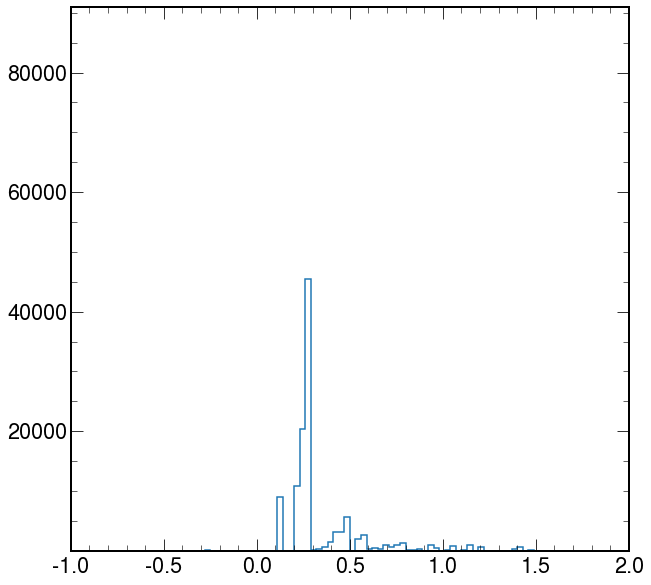

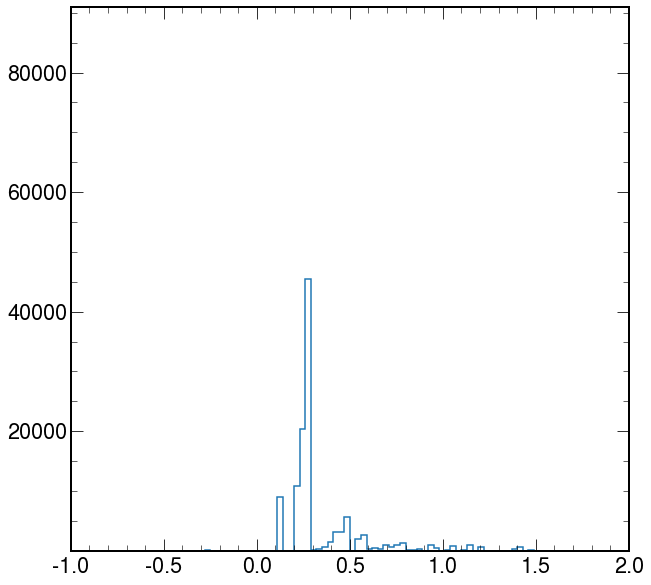

In [43]:
from yty_hist_class import yty_histplot
test_weight_hist =  yty_histplot('mjj',1,np.linspace(-1,2,100+1))
test_weight_hist.append_values('mine',[nonp_weight])
test_weight_hist.draw()

Create type 1 hist_plot named "mjj".
Histplot:mjj	No label named "pure_prompt"
draw  tight_leptons
draw  non_prompt_leptons
draw  pure_prompt


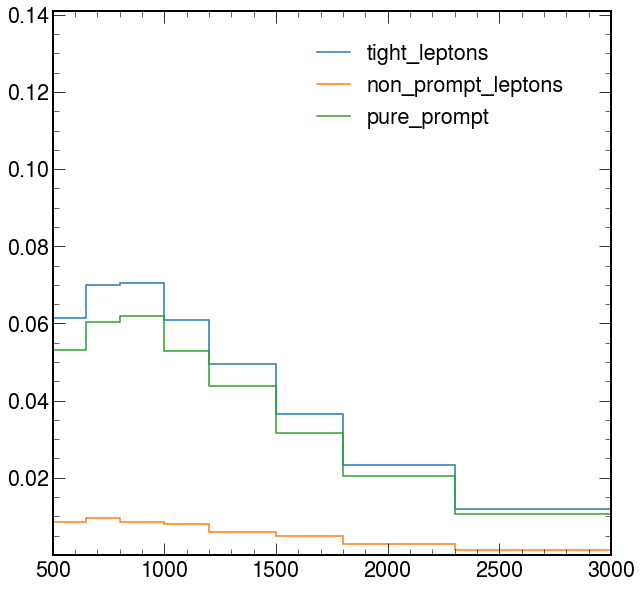

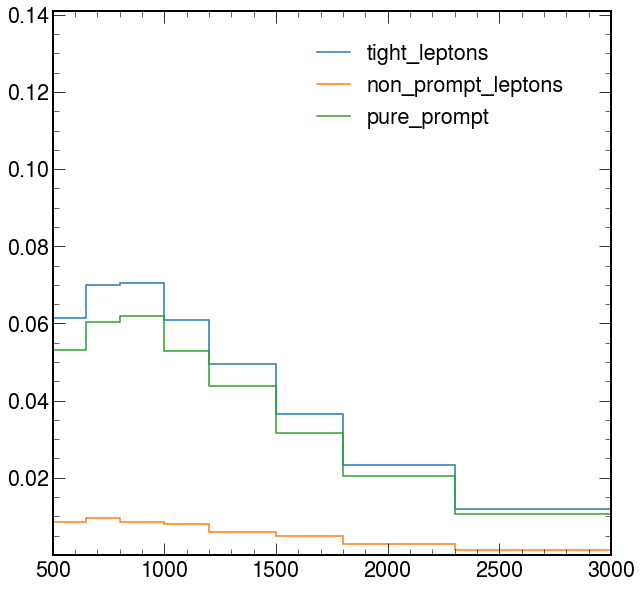

In [46]:

default_mjj_histbins = [500., 650., 800., 1000., 1200., 1500., 1800., 2300., 3000.]
mjj_histbins = np.linspace(0,3000,20)
mjj_hist = yty_histplot('mjj',1,default_mjj_histbins)
# mll_hist = yty_histplot('mll',1,[20., 80., 140., 240., 500])

tight_leptons_mjj = (tight_leptons_jets[:,0]+tight_leptons_jets[:,1]).mass
non_prompt_mjj = (not_both_tight_leptons_jets[:,0]+not_both_tight_leptons_jets[:,1]).mass
tight_leptons_weight = events_after_sel.Generator.weight[tight_leps_sel]

mc = 0.02597
Lumi = 59.7e+03
mc_weight = mc*Lumi/np.sum(events.Generator.weight)

mjj_hist.append_values('tight_leptons',[tight_leptons_mjj])
mjj_hist.append_weights('tight_leptons',[tight_leptons_weight*mc_weight])
mjj_hist.append_values('non_prompt_leptons',np.array([non_prompt_mjj]))
mjj_hist.append_weights('non_prompt_leptons',np.array([nonp_weight])*mc_weight)
mjj_hist.merge(['tight_leptons'],['non_prompt_leptons'],'pure_prompt')
mjj_hist.set_legend(legendbool=True)
mjj_hist.draw(['tight_leptons','non_prompt_leptons','pure_prompt'])

In [14]:
ak.Array(nonp_weight)

<Array [0.549, 0.276, 0.252, ... 0.276, 0.458] type='3503 * ?float64'>

In [15]:
tight_leptons_mjj

<Array [1.17e+03, 604, ... 1.64e+03, 755] type='9544 * ?float32'>

In [16]:
non_prompt_mjj

<Array [3.25e+03, 2.03e+03, ... 824, 1.97e+03] type='3503 * ?float32'>

In [17]:
mjj_hist.hists_dict['tight_leptons'].axes[0].edges

array([ 500.,  650.,  800., 1000., 1200., 1500., 1800., 2300., 3000.])

In [18]:
good_jets.fields

['area',
 'btagCMVA',
 'btagCSVV2',
 'btagDeepB',
 'btagDeepC',
 'btagDeepFlavB',
 'btagDeepFlavC',
 'chEmEF',
 'chFPV0EF',
 'chFPV1EF',
 'chFPV2EF',
 'chFPV3EF',
 'chHEF',
 'eta',
 'muEF',
 'muonSubtrFactor',
 'neEmEF',
 'neHEF',
 'phi',
 'puIdDisc',
 'qgl',
 'rawFactor',
 'bRegCorr',
 'bRegRes',
 'cRegCorr',
 'cRegRes',
 'electronIdx1',
 'electronIdx2',
 'jetId',
 'muonIdx1',
 'muonIdx2',
 'nConstituents',
 'nElectrons',
 'nMuons',
 'puId',
 'genJetIdx',
 'hadronFlavour',
 'partonFlavour',
 'cleanmask',
 'electronIdx1G',
 'electronIdx2G',
 'genJetIdxG',
 'muonIdx1G',
 'muonIdx2G',
 'muonIdxG',
 'electronIdxG',
 'isgood',
 'pt_orig',
 'mass_orig',
 'is_real',
 'pt_raw',
 'mass_raw',
 'pt_gen',
 'rho',
 'pt',
 'mass',
 'pt_JER_up',
 'pt_JER_down',
 'mass_JER_up',
 'mass_JER_down',
 'pt_JES_Absolute_up',
 'pt_JES_Absolute_down',
 'mass_JES_Absolute_up',
 'mass_JES_Absolute_down',
 'pt_JES_Absolute_2018_up',
 'pt_JES_Absolute_2018_down',
 'mass_JES_Absolute_2018_up',
 'mass_JES_Absolute_

In [19]:
index

<Array [[0, 1, 2, 3, 4], ... [0, 1, 2, 3, 4]] type='149400 * var * int64'>

In [20]:
good_jets.hadronFlavour

<Array [[0, 0, 0, 0, 0], ... [0, 0, 0, 0, 0]] type='149400 * var * int32[paramet...'>

In [21]:
cf_weight

<Array [0, 0.000836, 0, 0, 0.000217] type='5 * float64'>

In [22]:
events.HLT.fields

['AK4CaloJet100',
 'AK4CaloJet120',
 'AK4CaloJet30',
 'AK4CaloJet40',
 'AK4CaloJet50',
 'AK4CaloJet80',
 'AK4PFJet100',
 'AK4PFJet120',
 'AK4PFJet30',
 'AK4PFJet50',
 'AK4PFJet80',
 'AK8PFHT750_TrimMass50',
 'AK8PFHT800_TrimMass50',
 'AK8PFHT850_TrimMass50',
 'AK8PFHT900_TrimMass50',
 'AK8PFJet140',
 'AK8PFJet15',
 'AK8PFJet200',
 'AK8PFJet25',
 'AK8PFJet260',
 'AK8PFJet320',
 'AK8PFJet330_TrimMass30_PFAK8BTagDeepCSV_p1',
 'AK8PFJet330_TrimMass30_PFAK8BTagDeepCSV_p17',
 'AK8PFJet330_TrimMass30_PFAK8BoostedDoubleB_np2',
 'AK8PFJet330_TrimMass30_PFAK8BoostedDoubleB_np4',
 'AK8PFJet330_TrimMass30_PFAK8BoostedDoubleB_p02',
 'AK8PFJet360_TrimMass30',
 'AK8PFJet380_TrimMass30',
 'AK8PFJet40',
 'AK8PFJet400',
 'AK8PFJet400_TrimMass30',
 'AK8PFJet420_TrimMass30',
 'AK8PFJet450',
 'AK8PFJet500',
 'AK8PFJet550',
 'AK8PFJet60',
 'AK8PFJet80',
 'AK8PFJetFwd140',
 'AK8PFJetFwd15',
 'AK8PFJetFwd200',
 'AK8PFJetFwd25',
 'AK8PFJetFwd260',
 'AK8PFJetFwd320',
 'AK8PFJetFwd40',
 'AK8PFJetFwd400',
 'AK8PF

In [23]:
events_after_sel.Generator.weight

<Array [1, 1, 1, 1, 1, ... 1, 1, 1, 1, 0.99] type='13047 * ?float32[parameters={...'>

In [24]:
events.fields

['SoftActivityJetHT2',
 'ChsMET',
 'GenDressedLepton',
 'Generator',
 'LHEWeight',
 'OtherPV',
 'SubJet',
 'fixedGridRhoFastjetCentral',
 'RawMET',
 'event',
 'LHE',
 'L1simulation',
 'GenJetAK8',
 'SoftActivityJetHT5',
 'IsoTrack',
 'Photon',
 'L1Reco',
 'SV',
 'fixedGridRhoFastjetCentralCalo',
 'HLTriggerFinalPath',
 'FsrPhoton',
 'SoftActivityJetHT',
 'Flag',
 'PV',
 'Jet',
 'RawPuppiMET',
 'genWeight',
 'genTtbarId',
 'luminosityBlock',
 'btagWeight',
 'GenVisTau',
 'SoftActivityJetNjets2',
 'CaloMET',
 'LHEPdfWeight',
 'GenPart',
 'TkMET',
 'GenMET',
 'SoftActivityJetHT10',
 'LHEPart',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'HLT',
 'PSWeight',
 'SoftActivityJetNjets10',
 'MET',
 'SoftActivityJetNjets5',
 'run',
 'SubGenJetAK8',
 'LHEScaleWeight',
 'CorrT1METJet',
 'HTXS',
 'GenIsolatedPhoton',
 'Muon',
 'GenJet',
 'HLTriggerFirstPath',
 'Tau',
 'fixedGridRhoFastjetAll',
 'PuppiMET',
 'LHEReweightingWeight',
 'L1',
 'Pileup',
 'Electron',
 'FatJet',
 'TrigObj',
 'SoftActivity

In [25]:
taus.fields

['charge',
 'chargedIso',
 'cleanmask',
 'decayMode',
 'dxy',
 'dz',
 'eta',
 'genPartFlav',
 'genPartIdx',
 'genPartIdxG',
 'idAntiEle',
 'idAntiEle2018',
 'idAntiMu',
 'idDecayMode',
 'idDecayModeNewDMs',
 'idDeepTau2017v2p1VSe',
 'idDeepTau2017v2p1VSjet',
 'idDeepTau2017v2p1VSmu',
 'idMVAnewDM2017v2',
 'idMVAoldDM',
 'idMVAoldDM2017v1',
 'idMVAoldDM2017v2',
 'idMVAoldDMdR032017v2',
 'jetIdx',
 'jetIdxG',
 'leadTkDeltaEta',
 'leadTkDeltaPhi',
 'leadTkPtOverTauPt',
 'mass',
 'neutralIso',
 'phi',
 'photonsOutsideSignalCone',
 'pt',
 'puCorr',
 'rawAntiEle',
 'rawAntiEle2018',
 'rawAntiEleCat',
 'rawAntiEleCat2018',
 'rawDeepTau2017v2p1VSe',
 'rawDeepTau2017v2p1VSjet',
 'rawDeepTau2017v2p1VSmu',
 'rawIso',
 'rawIsodR03',
 'rawMVAnewDM2017v2',
 'rawMVAoldDM',
 'rawMVAoldDM2017v1',
 'rawMVAoldDM2017v2',
 'rawMVAoldDMdR032017v2']

In [26]:
taus.idMVAnewDM2017v2

<Array [[127, 127], [127], ... 127], [127, 7]] type='149400 * var * uint8[parame...'>

In [27]:
taus.idDecayModeNewDMs

<Array [[True, True], ... [True, True]] type='149400 * var * bool[parameters={"_...'>

In [28]:
taus.cleanmask

<Array [[1, 1], [1], [1, ... [1, 1], [1, 1]] type='149400 * var * uint8[paramete...'>

In [29]:
taus.idDeepTau2017v2p1VSe

<Array [[255, 3], [0], ... 127, 255], [0, 31]] type='149400 * var * uint8[parame...'>

In [30]:
np.sum((taus.decayMode==3) | (taus.decayMode==4))

0

In [31]:
np.sum((taus.decayMode!=5) & (taus.decayMode!=6))

225113

In [32]:
np.sum(taus.idDecayModeNewDMs==False)

0

In [33]:
good_tau_sel

<Array [[0, 0], [0], [0, ... [0, 1], [0, 0]] type='149400 * var * uint8'>

In [34]:
os.listdir('/data/pubfs/pku_visitor/public_write/download/datasets/nanov7/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/NANOAODSIM')

['77F36D6F-1209-B242-BEEF-66CB4A785A78.root',
 'DB735CFE-2E39-324E-A1B9-4B798235959E.root',
 '970CFDF1-F82B-764A-B0C2-F72462DB031D.root',
 '47B65D32-735E-C94C-B352-8F4E1A18B3A6.root',
 '93195E83-70B4-5848-AD36-DD562E44EB43.root',
 '9E3461B2-6CA4-F444-ABDF-3B890FEB32BB.root',
 '43FC6DD5-C2F1-F847-8F6A-EE1480BAB9E1.root',
 '86C92CED-B42E-3C46-8F9C-9C195EF44655.root',
 'DBD32736-2540-4145-BAF6-AE20BF1D4544.root',
 '1A376B9E-9A7E-8540-B9D5-E51DA8F89DBB.root',
 '10A4E7FB-AE45-954A-84AD-D69540D5C59A.root',
 '2D494ABA-4415-6246-8136-C48D11A2F80B.root',
 '4F43E8B6-0634-034E-931F-F5DD30DA3302.root',
 '441063D2-9CEE-8043-9CC8-9BA75D26463F.root',
 '5DA1002C-6CFC-3843-8A69-68FDDFFB19A2.root',
 '480549D3-C835-5648-ADD8-4E90F771A463.root',
 '2CCBC68D-FB53-384B-A2BB-98F79215FC17.root',
 '31971833-48FA-4242-B0F3-20DB7365C780.root',
 '15F719CB-CB32-FD48-8DCA-8BB53496CCCA.root',
 '5973143C-C4F0-2E46-894F-0165FA1BB01B.root',
 '83C2832F-611A-E34C-AEC2-08E5007D5AD5.root',
 '53B042AE-E840-5643-8913-F8E9083D

In [35]:
for ibr in taus.fields:
    print(type(taus[ibr]))

<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Array'>
<class 'awkwar

In [37]:
ntau_test_1

<Array [True, True, True, ... True, True, True] type='42786 * bool'>

In [ ]:
file = up.recreate("example.root")
file

In [ ]:
file["tree1"] = up.newtree(